In [20]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from seaborn import set_style
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from mpl_toolkits import mplot3d
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
set_style("whitegrid")


In [2]:
clTrials = pd.read_csv("Cleaned_and_Modified_Data.csv")

In [ ]:
clTrials

In [3]:
clTrials_train, clTrials_test = train_test_split(clTrials.copy(), 
                                            shuffle=True,
                                            random_state=314,
                                            stratify=clTrials['Completed_Status'],
                                            test_size=.2)

### Produce K-fold cross validation sets

In [ ]:
kfold = StratifiedKFold(5, shuffle=True, random_state=314)
for train_index, test_index in kfold.split(clTrials_train, clTrials_train['Completed_Status']):
    ## get the kfold training data
    ## X_tt
    X_train_train = X_train[train_index,:]
    y_train_train = y_train[train_index]
    
    ## get the holdout data
    X_holdout = X_train[test_index,:]
    y_holdout = y_train[test_index]

In [4]:
clTrials_completed = clTrials[clTrials["Status"]=="Completed"]
clTrials_not_completed = clTrials[clTrials["Status"]!="Completed"]

In [5]:
clTrials_train_modified = clTrials_train[clTrials_train['Enrollment'] <= 1500]
clTrials_test_modified = clTrials_test[clTrials_test['Enrollment'] <= 1500]

## Use k-nearest neighbor model.

In [ ]:
TEST = list(clTrials_test_modified['Completed_Status'])

# Function that applies knn to k neighbours with features p,q,r
def knn_for_three_features_pred(k,p,q,r):
    a = KNeighborsClassifier(k)
    a.fit(clTrials_train_modified[[p, q, r]],clTrials_train_modified.Completed_Status)
    return a.predict(clTrials_test_modified[[p, q, r]])
def knn_for_three_features_err(k,p,q,r):
    c=0
    for i in range(len(knn_for_three_features_pred(k,p,q,r))):
        if knn_for_three_features_pred(k,p,q,r)[i] == TEST[i]:
            c = c+1
    return c/len(knn_for_three_features_pred(k,p,q,r))

In [ ]:
# For graphing the number of neighbours for knn versus error
inp = [2*i+1 for i in range(18)]
def graph(p,q,r):
    out = [knn_for_three_features_err(k,p,q,r) for k in inp]
    plt.plot(inp,out)

In [ ]:
graph("Enrollment","Study Duration (months)","Intervention Model")

In [ ]:
graph("Enrollment","Study Duration (months)","Minimum Age")

In [ ]:
graph("Enrollment","Study Duration (months)","Hospital")

### So far, it seems to us that, only 2 features are important, namely Enrollment and Study Duration. Therefore, we now apply KNN to only these two features

In [ ]:
# Function that applies knn to k neighbours with features p,q
def knn_for_two_features_pred(k,p,q):
    a = KNeighborsClassifier(k)
    a.fit(clTrials_train_modified[[p, q]],clTrials_train_modified.Completed_Status)
    return a.predict(clTrials_test_modified[[p, q]])
def knn_for_two_features_err(k,p,q):
    c=0
    for i in range(len(knn_for_two_features_pred(k,p,q))):
        if knn_for_two_features_pred(k,p,q)[i] == TEST[i]:
            c = c+1
    return c/len(knn_for_two_features_pred(k,p,q))

In [ ]:
plt.plot(inp, [knn_for_two_features_err(k,"Enrollment","Study Duration (months)") for k in inp])

### With k-nearest approach, where k=5, we get 80% accuracy. With k = 27, we get ~83%

In [ ]:
#Confusion Matrix
#Decide what y values to use!
sklearn.metrics.confusion_matrix(y_true, y_pred)

## Now use Decision Tree Classifier

In [ ]:
# Defining a function that takes depth of the decision tree and features as input and gives out acurracy
TEST = list(clTrials_test['Completed_Status'])
def decision_tree(depth,features):
    X = np.array([[list(clTrials_train[features[j]])[i] for j in range(len(features))] for i in range(len(clTrials_train["Enrollment"]))])
    y = np.array(clTrials_train["Completed_Status"])
    X_test = np.array([[list(clTrials_test[features[j]])[i] for j in range(len(features))] for i in range(len(clTrials_test["Enrollment"]))])
    tree = DecisionTreeClassifier(max_depth  = depth)
    tree.fit(X,y)
    preds = tree.predict(X_test)
    c=0
    for j in range(len(preds)):
        if preds[j] == TEST[j]:
            c = c+1
    return c/len(preds)
    

In [ ]:
decision_tree(5,["Enrollment","Minimum Age","Study Duration (months)"])

In [ ]:
#to show overfitting as we increase the depth, we introduce the accuracy function on the tranining set.
TRAIN = list(clTrials_train['Completed_Status'])
def decision_tree_on_training_set(depth,features):
    X = np.array([[list(clTrials_train[features[j]])[i] for j in range(len(features))] for i in range(len(clTrials_train["Enrollment"]))])
    y = np.array(clTrials_train["Completed_Status"])
    #X_test = np.array([[list(clTrials_test[features[j]])[i] for j in range(len(features))] for i in range(len(clTrials_test["Enrollment"]))])
    tree = DecisionTreeClassifier(max_depth  = depth)
    tree.fit(X,y)
    preds = tree.predict(X)
    c=0
    for j in range(len(preds)):
        if preds[j] == TRAIN[j]:
            c = c+1
    return c/len(preds)

In [ ]:
decision_tree_on_training_set(5,["Enrollment","Minimum Age","Study Duration (months)"])

In [ ]:
Features = ["Enrollment","Study Duration (months)"]
b = [decision_tree(i,Features) for i in range(1,16)]
b

In [ ]:
plt.plot(range(1,16),b)

In [ ]:
c = [decision_tree_on_training_set(i,Features) for i in range(1,16)]
c

In [ ]:
plt.plot(range(1,16),c)

In [ ]:
plt.figure(figsize = (10,8))
plt.plot(range(1,16),b,color = 'blue',label = "Accuracy of Prediction")
plt.plot(range(1,16),c,color = 'green',label = "Accuracy of Training set")
plt.legend(loc = "upper left")
plt.show()

In [ ]:
# xx1, xx2 = np.meshgrid(np.arange(-.01, 1.01, .01),
#                           np.arange(-.01, 1.01, .01))

# X_pred = np.zeros((len(xx1.reshape(-1,1)), 2))
# X_pred[:,0] = xx1.flatten()
#X_pred[:,1] = xx2.flatten()
X = np.array([[list(clTrials_train["Study Duration (months)"])[i],list(clTrials_train["Enrollment"])[i]] for i in range(len(clTrials_train["Enrollment"]))])
y = np.array(clTrials_train["Completed_Status"])

X_pred = np.array([[list(clTrials_test["Study Duration (months)"])[i],list(clTrials_test["Enrollment"])[i]] for i in range(len(clTrials_test["Enrollment"]))])


for i in range(1,11):
    tree = DecisionTreeClassifier(max_depth  = i)
    
    tree.fit(X, y)
    
    preds = tree.predict(X_pred)
    
    plt.figure(figsize=(10,8))

    plt.scatter(X_pred[preds==0,0],
                X_pred[preds==0,1],
                alpha=.1,
                c='lightblue',
                s=100)
    plt.scatter(X_pred[preds==1,0],
                X_pred[preds==1,1],
                alpha=.1,
                c='orange',
                s=100)
    
    plt.scatter(X[y==0,0], 
                X[y==0,1],
                label='Training 0',
                c = 'darkblue',
                edgecolor='black',
                s=100)
    plt.scatter(X[y==1,0], 
                X[y==1,1],
                label='Training 1',
                c = 'darkorange',
                marker='v',
                edgecolor='black',
                s=100)
    
    plt.title("Maximum Depth of " + str(i), fontsize=20)
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$x_2$", fontsize=18)
    plt.legend(fontsize=14)
    
    plt.show()


### We do not even see the staircase shape of the decision tree because the two different types of data are mixed with each other. This might suggest Decision Trees might not be the best approach for this data set.

## We will now try a few different types of Support Vector Machines

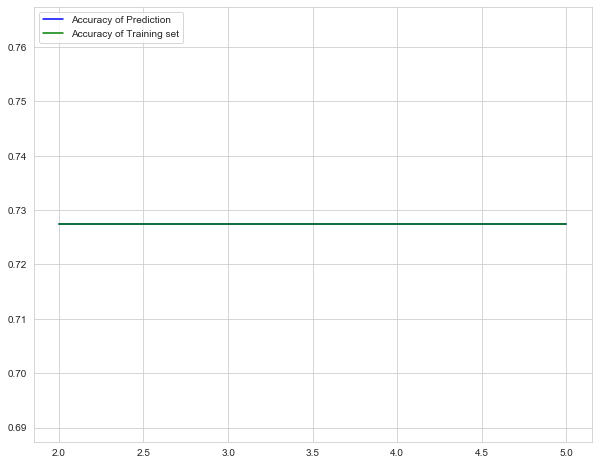

In [9]:
## We start with the 2D svc model and try to decide which degree of the polynomial will result in the best solution
TEST = list(clTrials_test['Completed_Status'])
TRAIN = list(clTrials_train['Completed_Status'])

def train_SVC(ker, deg, features):
    X = np.array([[list(clTrials_train[features[j]])[i] for j in range(len(features))] for i in range(len(clTrials_train["Enrollment"]))])
    y = np.array(clTrials_train["Completed_Status"])
    if ker = 'poly':
            svc_ker = SVC(kernel = 'poly', degree=deg, C=10)
    else:
            svc_ker = SVC(kernel = ker, C=10)

    svc_ker.fit(X,y)
    preds = svc_ker.predict(X)
    c=0
    for j in range(len(preds)):
        if preds[j] == TRAIN[j]:
            c = c+1
    return c/len(preds)
            
def test_SVC(ker, deg, features):
    X = np.array([[list(clTrials_train[features[j]])[i] for j in range(len(features))] for i in range(len(clTrials_train["Enrollment"]))])
    y = np.array(clTrials_train["Completed_Status"])
    X_test = np.array([[list(clTrials_test[features[j]])[i] for j in range(len(features))] for i in range(len(clTrials_test["Enrollment"]))])
    if ker = 'poly':
            svc_ker = SVC(kernel = 'poly', degree=deg, C=10)
    else:
            svc_ker = SVC(kernel = ker, C=10)
    svc_ker.fit(X,y)
    preds = svc_ker.predict(X_test)
    c=0
    for j in range(len(preds)):
        if preds[j] == TEST[j]:
            c = c+1
    return c/len(preds)


Features = ["Enrollment","Study Duration (months)"]

acc_train = [train_SVC(i,Features) for i in range(2,6)]
acc_test = [test_SVC(i,Features) for i in range(2,6)]
            
plt.figure(figsize = (10,8))
plt.plot(range(2,6),acc_test,color = 'blue',label = "Accuracy of Prediction")
plt.plot(range(2,6),acc_train,color = 'green',label = "Accuracy of Training set")
plt.legend(loc = "upper left")
plt.show()

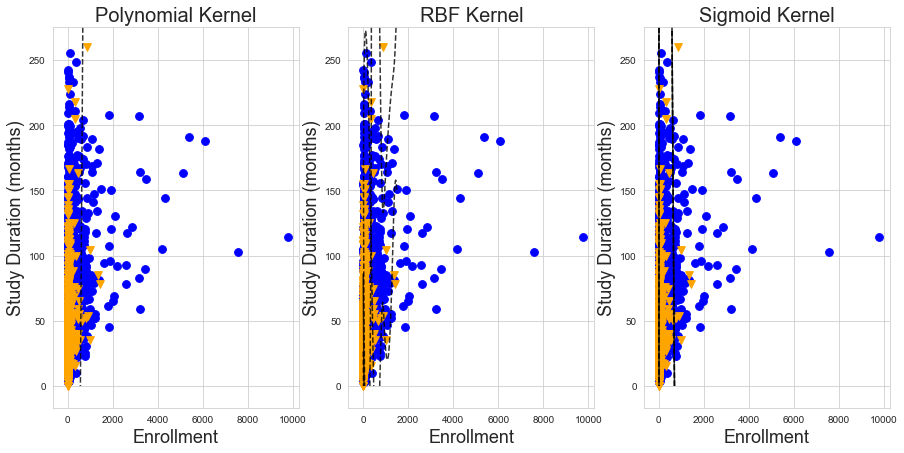

In [12]:
## Using the result above, we will test the poly SVC with the RBF SVC in 2D 

## one with poly, degree=2, C = 10
svc_poly = SVC(kernel = 'poly', degree=2, C=10)

## one with rbf kernel, C = 10
svc_rbf = SVC(kernel = 'rbf', C = 10)

## one with sigmoid, C = 10
svc_sig = SVC(kernel = 'sigmoid', C = 10)

## fit a model

svc_poly.fit(clTrials_train[['Enrollment', 'Study Duration (months)']], clTrials_train.Completed_Status)
svc_rbf.fit(clTrials_train[['Enrollment', 'Study Duration (months)']], clTrials_train.Completed_Status)
svc_sig.fit(clTrials_train[['Enrollment', 'Study Duration (months)']], clTrials_train.Completed_Status)

# get a grid of x1 values
x1x1 = np.linspace(0, 1500, 100)

# get a grid of x2 values
x2x2 = np.linspace(0, 275, 100)

# arrange them in a 2D grid
X1X1, X2X2 = np.meshgrid(x1x1, x2x2)

# make a cleaner array
x1x2 = np.vstack([X1X1.ravel(), X2X2.ravel()]).T

# get the value of the decision function for this grid
Z_poly = svc_poly.decision_function(x1x2).reshape(X1X1.shape)
Z_rbf = svc_rbf.decision_function(x1x2).reshape(X1X1.shape)
Z_sig = svc_sig.decision_function(x1x2).reshape(X1X1.shape)


## Make a figure

fig,ax = plt.subplots(1,3,figsize=(15,7))

## plot the training data
ax[0].scatter(clTrials_train.loc[clTrials_train.Status=='Completed']['Enrollment'],
        clTrials_train.loc[clTrials_train.Status =='Completed']['Study Duration (months)'],
        c='blue',
        s=60,
        label="Not Completed")

ax[0].scatter(clTrials_train.loc[clTrials_train.Status !='Completed']['Enrollment'],
        clTrials_train.loc[clTrials_train.Status !='Completed']['Study Duration (months)'],
        c='orange',
        s=60,
        marker='v',
        label="Completed")

ax[1].scatter(clTrials_train.loc[clTrials_train.Status=='Completed']['Enrollment'],
        clTrials_train.loc[clTrials_train.Status =='Completed']['Study Duration (months)'],
        c='blue',
        s=60,
        label="Not Completed")

ax[1].scatter(clTrials_train.loc[clTrials_train.Status !='Completed']['Enrollment'],
        clTrials_train.loc[clTrials_train.Status !='Completed']['Study Duration (months)'],
        c='orange',
        s=60,
        marker='v',
        label="Completed")

ax[2].scatter(clTrials_train.loc[clTrials_train.Status=='Completed']['Enrollment'],
        clTrials_train.loc[clTrials_train.Status =='Completed']['Study Duration (months)'],
        c='blue',
        s=60,
        label="Not Completed")

ax[2].scatter(clTrials_train.loc[clTrials_train.Status !='Completed']['Enrollment'],
        clTrials_train.loc[clTrials_train.Status !='Completed']['Study Duration (months)'],
        c='orange',
        s=60,
        marker='v',
        label="Completed")


## plot the separating line, and the margins
ax[0].contour(X1X1, X2X2, Z_poly,
              colors='k', levels=[-1,0,1], 
              alpha=.8, linestyles=['--','-','--'])
ax[1].contour(X1X1, X2X2, Z_rbf,
              colors='k', levels=[-1,0,1], 
              alpha=.8, linestyles=['--','-','--'])
ax[2].contour(X1X1, X2X2, Z_sig,
              colors='k', levels=[-1,0,1], 
              alpha=.8, linestyles=['--','-','--'])


ax[0].set_title("Polynomial Kernel", fontsize=20)
ax[1].set_title("RBF Kernel", fontsize=20)
ax[2].set_title("Sigmoid Kernel", fontsize=20)


ax[0].set_xlabel("Enrollment", fontsize=18)
ax[1].set_xlabel("Enrollment", fontsize=18)
ax[2].set_xlabel("Enrollment", fontsize=18)
ax[0].set_ylabel("Study Duration (months)", fontsize=18)
ax[1].set_ylabel("Study Duration (months)", fontsize=18)
ax[2].set_ylabel("Study Duration (months)", fontsize=18)

plt.show()

In [ ]:
Pred_svc_poly = svc_poly.predict(clTrials_test_modified[['Enrollment','Study Duration (months)']])
Pred_svc_rbf = svc_rbf.predict(clTrials_test_modified[['Enrollment','Study Duration (months)']])
Pred_svc_sig = svc_sig.predict(clTrials_test_modified[['Enrollment','Study Duration (months)']])

In [22]:
def train_SVC_con(y, ker, deg, features):
    X = np.array([[list(clTrials_train[features[j]])[i] for j in range(len(features))] for i in range(len(clTrials_train["Enrollment"]))])
    if ker == 'poly':
            svc_ker = SVC(kernel = 'poly', degree=deg, C=10)
    else:
            svc_ker = SVC(kernel = ker, C=10)

    svc_ker.fit(X,y)
    
    return svc_ker.predict(X)

def accuracy(preds):
    c = 0
    for j in range(len(preds)):
        if preds[j] == TRAIN[j]:
            c = c+1
    return c/len(preds)

def f1_score(recall, precision):
    return 2*(recall)*precision/(recall+precision)


## We also try the 3D version of the models adding in the minimum age feature
y = np.array(clTrials_train["Completed_Status"])

features = ['Enrollment', 'Study Duration (months)', 'Minimum Age']
## one with poly, degree=2, C = 10

preds = train_SVC_con(y, 'poly',  2, features)
TN_poly = confusion_matrix(y, preds)[0,0]
FP_poly = confusion_matrix(y, preds)[0,1]
FN_poly = confusion_matrix(y, preds)[1,0]
TP_poly = confusion_matrix(y, preds)[1,1]

ac_poly = accuracy(preds)
pr_poly = np.round(TP_poly/(FP_poly + TP_poly), 4)
re_poly = np.round(TP_poly/(FN_poly + TP_poly), 4)
f1_poly = f1_score(re_poly, pr_poly)
ROC_poly = (np.round(TP_poly/(TP_poly+FN_poly),4) + np.round(TN_poly/(TN_poly+FP_poly),4))/2
print(ac_poly)
print(pr_poly)
print(re_poly)  
print(f1_poly) 
print(ROC_poly)

preds = train_SVC_con(y, 'rbf',  2, features)
TN_rbf = confusion_matrix(y, preds)[0,0]
FP_rbf = confusion_matrix(y, preds)[0,1]
FN_rbf = confusion_matrix(y, preds)[1,0]
TP_rbf = confusion_matrix(y, preds)[1,1]

ac_rbf = accuracy(preds)
pr_rbf = np.round(TP_rbf/(FP_rbf + TP_rbf), 4)
re_rbf = np.round(TP_rbf/(FN_rbf + TP_rbf), 4)
f1_rbf = f1_score(re_rbf, pr_rbf)
ROC_rbf = (np.round(TP_rbf/(TP_rbf+FN_rbf),4) + np.round(TN_rbf/(TN_rbf+FP_rbf),4))/2
print(ac_rbf)
print(pr_rbf)
print(re_rbf)
print(f1_rbf)
print(ROC_rbf)


preds = train_SVC_con(y, 'sigmoid', 2, features)
TN_sig = confusion_matrix(y, preds)[0,0]
FP_sig = confusion_matrix(y, preds)[0,1]
FN_sig = confusion_matrix(y, preds)[1,0]
TP_sig = confusion_matrix(y, preds)[1,1]

ac_sig = accuracy(preds)
pr_sig = np.round(TP_sig/(FP_sig + TP_sig), 4)
re_sig = np.round(TP_sig/(FN_sig + TP_sig), 4)
f1_sig = f1_score(re_sig, pr_sig)
ROC_sig = (np.round(TP_sig/(TP_sig+FN_sig),4) + np.round(TN_sig/(TN_sig+FP_sig),4))/2

print(ac_sig)
print(pr_sig)
print(re_sig)  
print(f1_sig) 
print(ROC_sig)


0.7273755656108597
0.7274
1.0
0.8421905754312841
0.5
0.8085407239819005
0.8412
0.9082
0.8734169886818336
0.7253499999999999
0.7893099547511312
0.8553
0.855
0.8551499736888265
0.73455


In [25]:
def test_SVC_con(ker, deg, features):
    X = np.array([[list(clTrials_train[features[j]])[i] for j in range(len(features))] for i in range(len(clTrials_train["Enrollment"]))])
    y = np.array(clTrials_train["Completed_Status"])

    if ker == 'poly':
            svc_ker = SVC(kernel = 'poly', degree=deg, C=10)
    else:
            svc_ker = SVC(kernel = ker, C=10)

    svc_ker.fit(X,y)
    X_test = np.array([[list(clTrials_test[features[j]])[i] for j in range(len(features))] for i in range(len(clTrials_test["Enrollment"]))])

    return svc_ker.predict(X_test)

def accuracy_test(preds):
    c = 0
    for j in range(len(preds)):
        if preds[j] == TEST[j]:
            c = c+1
    return c/len(preds)

def f1_score(recall, precision):
    return 2*(recall)*precision/(recall+precision)


## We also try the 3D version of the models adding in the minimum age feature
y = np.array(clTrials_test["Completed_Status"])

features = ['Enrollment', 'Study Duration (months)', 'Minimum Age']
## one with poly, degree=2, C = 10

preds = test_SVC_con('rbf',  2, features)
TN_rbf = confusion_matrix(y, preds)[0,0]
FP_rbf = confusion_matrix(y, preds)[0,1]
FN_rbf = confusion_matrix(y, preds)[1,0]
TP_rbf = confusion_matrix(y, preds)[1,1]

ac_rbf = accuracy_test(preds)
pr_rbf = np.round(TP_rbf/(FP_rbf + TP_rbf), 4)
re_rbf = np.round(TP_rbf/(FN_rbf + TP_rbf), 4)
f1_rbf = f1_score(re_rbf, pr_rbf)
ROC_rbf = (np.round(TP_rbf/(TP_rbf+FN_rbf),4) + np.round(TN_rbf/(TN_rbf+FP_rbf),4))/2
print(ac_rbf)
print(pr_rbf)
print(re_rbf)
print(f1_rbf)
print(ROC_rbf)


preds = test_SVC_con( 'sigmoid', 2, features)
TN_sig = confusion_matrix(y, preds)[0,0]
FP_sig = confusion_matrix(y, preds)[0,1]
FN_sig = confusion_matrix(y, preds)[1,0]
TP_sig = confusion_matrix(y, preds)[1,1]

ac_sig = accuracy_test(preds)
pr_sig = np.round(TP_sig/(FP_sig + TP_sig), 4)
re_sig = np.round(TP_sig/(FN_sig + TP_sig), 4)
f1_sig = f1_score(re_sig, pr_sig)
ROC_sig = (np.round(TP_sig/(TP_sig+FN_sig),4) + np.round(TN_sig/(TN_sig+FP_sig),4))/2

print(ac_sig)
print(pr_sig)
print(re_sig)  
print(f1_sig) 
print(ROC_sig)


0.8235294117647058
0.8504
0.9191
0.8834163775077706
0.7438
0.7895927601809954
0.8633
0.8445
0.853796521840965
0.74385
